<a href="https://colab.research.google.com/github/TheDon57/MODS_Exercises/blob/main/Week_8_exercise/Clustering_Week_08_Basketball.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import random
# Set seed for reproducibility
np.random.seed(42)  # Set seed for NumPy
random.seed(42) # Set seed for random module

## Introduction

In this weeks tutorial we will start with unsupervised learning. Until now we always had the goal to approximate the relationship of an output variable and multiple inputs, where the output as well as the inputs could be numerical or categorical.  

In unsupervised learning there is no direct target variable, meaning we are not approximating a prediction function but are rather searching for interesting patterns within the given data.  
One such unsupervised learning method is __Clustering__. In clustering we want to group (cluster) homogeneous instances while maximizing the heterogeneity of different clusters.

For demonstration we will use a data set of [Basketball player statistics](https://www.kaggle.com/jacobbaruch/basketball-players-stats-per-season-49-leagues) which includes information about basketball players from all around the world.

In [2]:
import pandas as pd
# Loading the data from a csv file
data = pd.read_csv("https://raw.githubusercontent.com/kbrennig/MODS_WS25_26/refs/heads/main/data/players_stats_by_season_full_details.csv")

## Explore Data
First of all, let's have a look at the raw data. It seems like it is sorted by the league and the season, then for each player there is basic information like birthday and height. Additionally there are a bunch of interesting metrics for the game of basketball, which are shortly defined below:  

- 'GP': Games Played
- 'MIN': Minutes Played
- 'FGM': Field Goals Made
- 'FGA': Field Goals Attempts
- '3PM': Three Points Made
- '3PA': Three Points Attempts
- 'FTM': Free Throws Made
- 'FTA': Free Throws Attempts
- 'TOV': Turnovers
- 'PF': Personal Fouls
- 'ORB': Offensive Rebounds
- 'DRB': Defensive Rebounds
- 'REB': Rebounds
- 'AST': Assists
- 'STL': Steals
- 'BLK': Blocks
- 'PTS': Points

*Run the code below.*

In [3]:
print(data.describe())

                 GP           MIN           FGM           FGA           3PM  \
count  36950.000000  36950.000000  36950.000000  36950.000000  36950.000000   
mean      31.401083    781.178506    117.838268    254.699648     30.616969   
std       16.112989    470.295971     91.730585    191.015086     30.658528   
min        1.000000      0.700000      0.000000      0.000000      0.000000   
25%       22.000000    476.000000     57.000000    131.000000      7.000000   
50%       31.000000    726.000000     99.000000    217.000000     23.000000   
75%       38.000000    983.200000    151.000000    323.000000     45.000000   
max       83.000000   3239.300000    857.000000   1941.000000    402.000000   

                3PA           FTM           FTA           TOV            PF  \
count  36950.000000  36950.000000  36950.000000  36950.000000  36950.000000   
mean      87.107876     57.238484     77.404980     49.160162     72.323978   
std       80.451297     53.446822     68.662186    

## Transform Data

### Filter the data and standardize columns

When we look at the data, we quickly see, that it contains multiple records for one player. This most likely results from the fact that there are multiple season contained in the data. It could definitely be interesting to compare one player to previous versions of himself but for our purpose of clustering it is rather disadvantageous so we will filter the data for only one season. Additionally we will constrain the league to be the NBA.  
So the resulting data contains information about players in the NBA in the 2018 - 2019 season.

We also drop some columns since we will focus on a few key performance indicators.  

And lastly we standardize the remaining columns, which is necessary for clustering when the variables have different units.

*Run the code below.*


In [4]:
# Filter the data for NBA 2018-2019 season
dataset_for_clustering = data[(data['League'] == 'NBA') & (data['Season'] == '2018 - 2019')]

# Drop irrelevant columns
dataset_for_clustering = dataset_for_clustering.drop(columns=['high_school', 'nationality', 'weight', 'height', 'height_cm',
                                                              'weight_kg', 'birth_date', 'birth_month', 'birth_year',
                                                              'League', 'Season', 'Stage', 'FGA', '3PA', 'FTA', 'ORB',
                                                              'DRB', 'MIN'])

# Separate players and teams
players_and_teams = dataset_for_clustering[['Player', 'Team']]
dataset_for_clustering = dataset_for_clustering.drop(columns=['Player', 'Team'])

# Standardize the data
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
dataset_for_clustering_scaled = pd.DataFrame(scaler.fit_transform(dataset_for_clustering), columns=dataset_for_clustering.columns)

# Show summary of transformed data
print(dataset_for_clustering_scaled.describe())

                 GP         FGM           3PM         FTM           TOV  \
count  4.350000e+02  435.000000  4.350000e+02  435.000000  4.350000e+02   
mean  -6.533726e-17    0.000000  6.533726e-17    0.000000 -6.533726e-17   
std    1.001151e+00    1.001151  1.001151e+00    1.001151  1.001151e+00   
min   -1.616143e+00   -1.166936 -9.314751e-01   -0.921205 -1.087749e+00   
25%   -1.178018e+00   -0.906121 -8.043562e-01   -0.716997 -8.456102e-01   
50%    4.733766e-01   -0.161710 -2.958803e-01   -0.328029 -2.285462e-01   
75%    8.777998e-01    0.560965  5.303929e-01    0.386699  4.822490e-01   
max    1.113713e+00    3.413632  5.074896e+00    6.410836  4.957916e+00   

                 PF           REB           AST           STL           BLK  \
count  4.350000e+02  4.350000e+02  4.350000e+02  4.350000e+02  4.350000e+02   
mean  -1.960118e-16 -6.533726e-17  1.306745e-16  6.533726e-17  3.266863e-17   
std    1.001151e+00  1.001151e+00  1.001151e+00  1.001151e+00  1.001151e+00   
min   -1

## K-means Clustering

In the lecture two clustering approaches were explained. We will start with __K-means clustering__.




### Perform clustering

First, we need to configure our K-Means clustering model. In doing so we first define how many clusters should be formed using `n_clusters`. Based on this the algorithm will try to group our players into 4 meaningful clusters based on their stats. Second, with `n_init` we define to automatically choose how many times to run K-Means with different centroid seeds. This ensures more stable and reliable cluster results. Third, with defining `max_iter` we define the maximum number of iterations per run, meaning K-Means repeats its update steps (reassigning points to clusters, updating centroids) until convergence or until it hits 300 iterations.

Afterwards, we need to apply our K-Means to our dataset and store our entire model as `kmeans_cluster_model` and assigns to each row (i.e., each player) in the dataset a cluster.
  

*Run the code below.*

In [5]:
from sklearn.cluster import KMeans

# Perform K-means clustering with 4 clusters
kmeans = KMeans(n_clusters=4, n_init='auto', max_iter=300, random_state=42)
kmeans_cluster_model = kmeans.fit(dataset_for_clustering_scaled)

### Extract results

After fitting the K-Means model, `kmeans.labels_` contains the cluster assignment for each data point. Each element in `km_clusters` is an integer (e.g., 0, 1, 2, 3) indicating which cluster a sample belongs to. Thus, this gives us the information which player belongs to which cluster.

`kmeans.cluster_centers_` holds the coordinates of the cluster centroids in feature space. Each row corresponds to a cluster, and each column corresponds to a feature. Using `.T` the centroids matrix is transposed so that the features become rows and the clusters become columns. This layout is often more convenient for visualization or further processing. Thus, the `centroids` gives us the location of each cluster center.

*Run the code below.*

In [6]:
km_clusters = kmeans.labels_
# Extract centroids
centroids = kmeans.cluster_centers_.T

### Calculate silhoutte scores

Evaluating the performance of an unsupervised learning method is different compared to a supervised method.  
Since we are trying to learn a function in supervised learning and we are given the actual outputs of this (unknown) function we can simply compare the outputs of our learned function to the actual outputs and thereby relatively intuitively assess our learned models performance.

In clustering the goal is to cluster similar instances together and maximize the distance between clusters. One way to evaluate this kind of procedure is to look at the __distances__ and __compare__ for example the __distances__ an instance has to other instances in its __own cluster__ and to instances of __other clusters__.

The __silhouette score__ does exactly that.

To compute the average __silhouette score__ we use the function `silhouette_score`. Therefore we only need our dataset and the cluster labels `km_clusters` assigned by K-Means.
- Closer to 1: well-separated clusters
- Around 0: overlapping clusters.
- Negative: misassigned clusters.

*Run the code below.*

In [7]:
from sklearn.metrics import silhouette_score

# Calculate silhouette score
silhouette_score_avg_kmeans = silhouette_score(dataset_for_clustering_scaled, km_clusters)
print(f"Mean Silhouette Score: {silhouette_score_avg_kmeans}")

Mean Silhouette Score: 0.4307221457593341


### Find the optimal number of clusters

The number of clusters is a __hyperparameter__ which has to be explored. We can for example simply repeat the clustering for different numbers of clusters and compare their respective silhouette scores to determine, which number yields the best clustering.

Therefore, using `for i in range(2, 16):` we test different cluster numbers from 2 to 15. For each value `i`, a new K-Means model is created. The code here follows the same method demonstrated in the earlier code example. The only thing that changes is, that we need to define `n_clusters=i` instead of manually telling how many clusters need to be created.

*Run the code below.*

In [8]:
# Iterate over different numbers of clusters and calculate silhouette score
for i in range(2, 16):
    kmeans = KMeans(n_clusters=i, n_init='auto', max_iter=300, random_state=42)
    kmeans_cluster_model = kmeans.fit(dataset_for_clustering_scaled)
    km_clusters = kmeans.labels_

    silhouette_score_avg_kmeans = silhouette_score(dataset_for_clustering_scaled, km_clusters)
    print(f"Number of clusters: {i} - Silhouette score: {silhouette_score_avg_kmeans}")

Number of clusters: 2 - Silhouette score: 0.43732362828201393
Number of clusters: 3 - Silhouette score: 0.4348158150986768
Number of clusters: 4 - Silhouette score: 0.4307221457593341
Number of clusters: 5 - Silhouette score: 0.41019524458784673
Number of clusters: 6 - Silhouette score: 0.3750553915467234
Number of clusters: 7 - Silhouette score: 0.3750773518920066
Number of clusters: 8 - Silhouette score: 0.36910356711115894
Number of clusters: 9 - Silhouette score: 0.37072005478414466
Number of clusters: 10 - Silhouette score: 0.34381970236548176
Number of clusters: 11 - Silhouette score: 0.33199603098893815
Number of clusters: 12 - Silhouette score: 0.3338751232969291
Number of clusters: 13 - Silhouette score: 0.3250560760355024
Number of clusters: 14 - Silhouette score: 0.32558430351812817
Number of clusters: 15 - Silhouette score: 0.32132960231424285


### Visualize Clustering Results
Let's visualize the clustering results using a bar chart of the cluster centroids.

The code below depicts the resulting cluster centroids for two clusters (optimal number of clusters determined in previous step). The bar chart visualizes the centroids (i.e., the average feature values) of the two clusters detected by our K-means algorithm.

+ *How would you interpret the clustering results?*

*Run the code below.*

In [9]:
import plotly.graph_objects as go

# recalculate the model for two clusters
kmeans = KMeans(n_clusters=2, n_init='auto', max_iter=300, random_state=42)
kmeans_cluster_model = kmeans.fit(dataset_for_clustering_scaled)
km_clusters = kmeans.labels_
centroids = kmeans.cluster_centers_.T

# Plot the centroids for the clusters
centroids_df = pd.DataFrame(centroids.T, columns=dataset_for_clustering_scaled.columns)
clusters = [1, 2]

fig = go.Figure()
for column in centroids_df.columns:
    fig.add_trace(go.Bar(x=clusters, y=centroids_df[column], name=column))

fig.update_layout(yaxis_title='Count', barmode='group', title='K-means Clustering Results')
fig.show()

## Hierarchical Clustering
The second method presented in the lecture is **Hierarchical clustering**.
In **K-means clustering** we are randomly choosing centroids and try to cluster our data around these clusters.

Hierarchical clustering works different. Here we start by computing the **pairwise distances** (and later **intercluster distances**) for all instances and then iteratively combine the instances (and later clusters) which are the closest to each other into one cluster.

1. Compute all pairwise distances
- `pdist()` takes the standardized dataset and calculates the distance between every pair of observations. Here, the distance metric is Euclidean, meaning it measures straight-line distance in the feature space.
- The output `distances` is a condensed distance matrix — a flattened list of distances for all point pairs (not a full square matrix).

2. Build a hierarchical clustering model
- `linkage()` uses the pairwise distances to build a hierarchical clustering tree (dendrogram). The `method='complete'` parameter means complete linkage, where the distance between two clusters is defined as the maximum distance between any pair of points from the two clusters.
- The output `hcluster_model` contains the cluster merge history and distances, and can be used to plot a dendrogram or cut the tree into clusters.

### Perform clustering

*Run the code below.*

In [10]:
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage

# Calculate pairwise distances using Euclidean distance
distances = pdist(dataset_for_clustering_scaled, metric='euclidean')

# Perform hierarchical clustering using complete linkage
hcluster_model = linkage(distances, method='complete')

### Plot Dendrogram
Apart from the clustering itself, hierarchical clustering also produces a **dendrogram** as a side product. The dendrogram visualizes the order in which clusters are merged. Though it may be cluttered, the top part can show interesting insights.

*Run the code below.*


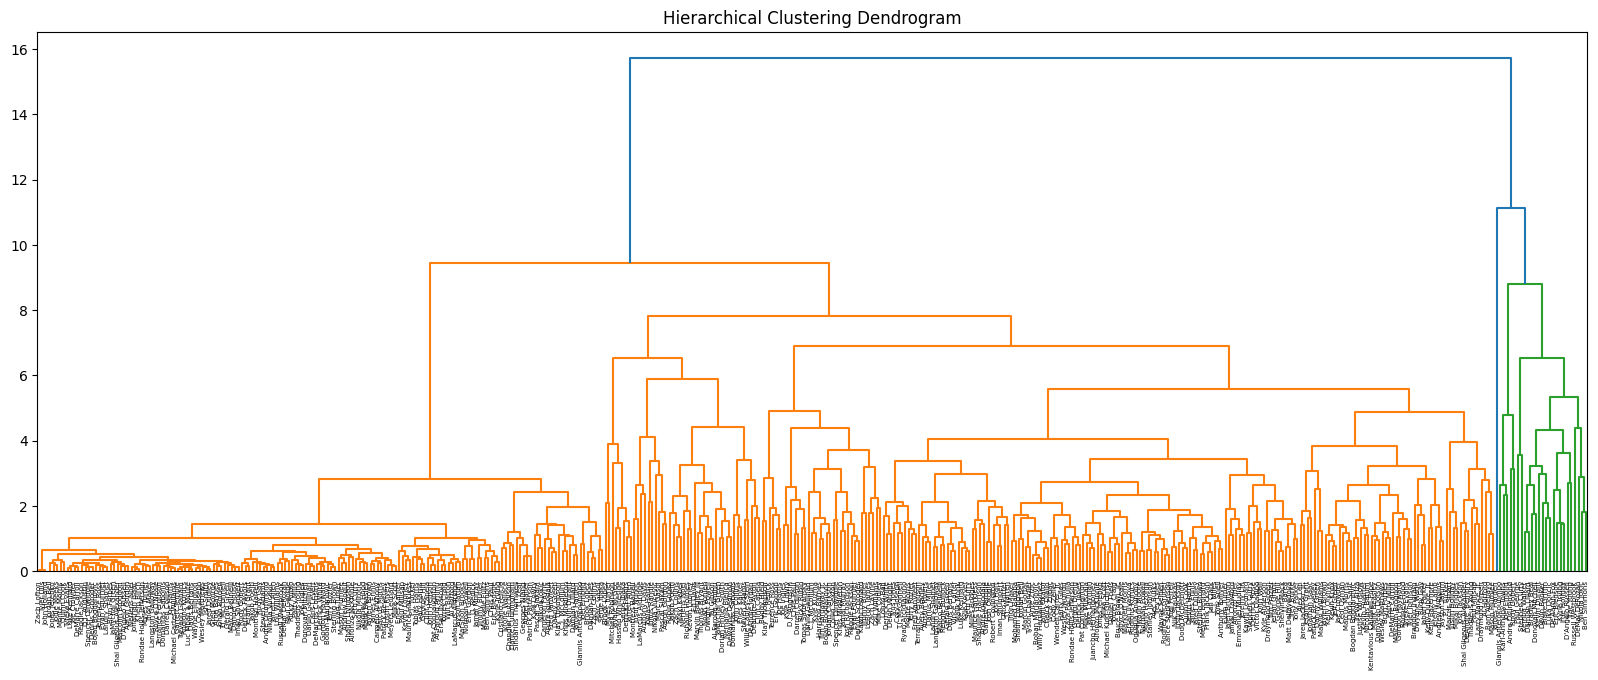

In [11]:
from scipy.cluster.hierarchy import dendrogram
import matplotlib.pyplot as plt

# Plot dendrogram
plt.figure(figsize=(20, 7))
dendrogram(
    hcluster_model,
    labels=players_and_teams['Player'].values,
    leaf_rotation=90,
    leaf_font_size=5
)
plt.title('Hierarchical Clustering Dendrogram')
plt.show()

### Cut Dendrogram
Once the hierarchical clustering is finished, we can extract clusterings for different numbers of clusters by simply cutting the dendrogram at the right position.

Here we extract cluster assignments from the hierarchical clustering results by splitting the dendrogram into 4 clusters.


*Run the code below.*

In [23]:
from scipy.cluster.hierarchy import cut_tree

# Cut dendrogram to form clusters
h_clusters = cut_tree(hcluster_model, n_clusters=4).flatten()


### Plot Dendrogram for two clusters

To visualize the clustering, we add a horizontal line at the threshold where the dendrogram is cut. This line highlights the level at which the clusters are formed, with branches below it automatically colored to indicate the distinct clusters.

*Run the code below.*

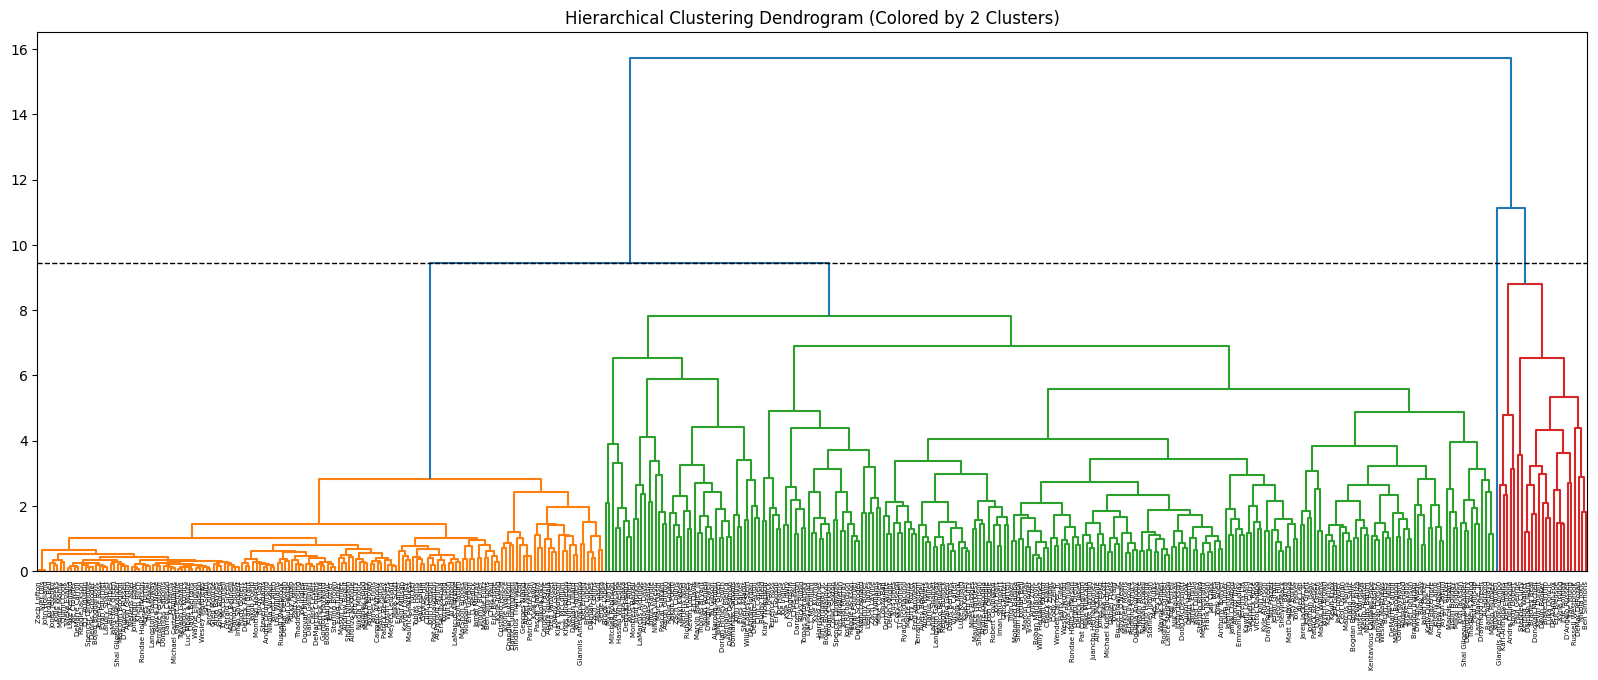

In [24]:
# Compute the flat clusters to confirm there are two clusters
num_clusters = 4

# Find the appropriate distance threshold for two clusters
# The threshold is typically the height at which the tree splits into the desired number of clusters
color_threshold = hcluster_model[-(num_clusters - 1), 2]  # The height of the last merge that creates 2 clusters

# Plot the dendrogram with the color threshold
plt.figure(figsize=(20, 7))
dendrogram(
    hcluster_model,
    labels=players_and_teams['Player'].values,
    leaf_rotation=90,
    leaf_font_size=5,
    color_threshold=color_threshold
)
plt.title('Hierarchical Clustering Dendrogram (Colored by 2 Clusters)')
plt.axhline(y=color_threshold, c='black', linestyle='--', lw=1)  # Add a line for the cut-off
plt.show()

### Calculate Silhouette Score
We'll evaluate the hierarchical clustering using the silhouette score.

*Run the code below.*

In [25]:
# Calculate silhouette score for hierarchical clustering
silhouette_score_avg_hc = silhouette_score(dataset_for_clustering_scaled, h_clusters)
print(f"Mean Silhouette Score for Hierarchical Clustering: {silhouette_score_avg_hc}")


Mean Silhouette Score for Hierarchical Clustering: 0.4276086078651798


### Find the Optimal Number of Clusters for Hierarchical Clustering
Similar to K-means, we can experiment with different cluster numbers to find the optimal configuration.

Therefore, we loop over cluster counts from 2 to 15. In the code we try different numbers of clusters `i` to evaluate which choice produces the best clustering structure.

We then cut the hierarchical clustering tree. The `hcluster_model` produced earlier is “cut” into `i` clusters.

Afterwards, we can calculate the `silhouette_score`.

*Run the code below.*

In [26]:
# Iterate over different numbers of clusters and calculate silhouette score for hierarchical clustering
for i in range(2, 16):
    h_clusters = cut_tree(hcluster_model, n_clusters=i).flatten()
    silhouette_score_avg_hc = silhouette_score(dataset_for_clustering_scaled, h_clusters)
    print(f"Number of clusters: {i} - Mean Silhouette score: {silhouette_score_avg_hc}")


Number of clusters: 2 - Mean Silhouette score: 0.4848630938585075
Number of clusters: 3 - Mean Silhouette score: 0.4667621911238542
Number of clusters: 4 - Mean Silhouette score: 0.4276086078651798
Number of clusters: 5 - Mean Silhouette score: 0.41554299701497377
Number of clusters: 6 - Mean Silhouette score: 0.38748296795883774
Number of clusters: 7 - Mean Silhouette score: 0.38553405806385854
Number of clusters: 8 - Mean Silhouette score: 0.3830063695740455
Number of clusters: 9 - Mean Silhouette score: 0.3789857219947083
Number of clusters: 10 - Mean Silhouette score: 0.3675315028861447
Number of clusters: 11 - Mean Silhouette score: 0.36590671322365353
Number of clusters: 12 - Mean Silhouette score: 0.3667708364667814
Number of clusters: 13 - Mean Silhouette score: 0.36309068247782456
Number of clusters: 14 - Mean Silhouette score: 0.35715993363440857
Number of clusters: 15 - Mean Silhouette score: 0.3590349466679177


## Summary
In this tutorial, we covered:
1. Performing K-means clustering and evaluating it using silhouette scores.
2. Visualizing clusters by plotting centroids.
3. Performing hierarchical clustering and visualizing it with a dendrogram.


*You can use the cell below to build and evaluate different clusterings*

In [39]:
# Enter your Code here!
# Cut dendrogram to form clusters
num_clusters = 4
h_clusters = cut_tree(hcluster_model, n_clusters=num_clusters).flatten()

# Calculate silhouette score for hierarchical clustering
silhouette_score_avg_hc = silhouette_score(dataset_for_clustering_scaled, h_clusters)
print(f"Mean Silhouette Score for Hierarchical Clustering: {silhouette_score_avg_hc}")

cluster_sizes = np.zeros((num_clusters,), dtype=np.int_)

for cluster in h_clusters:
  for i in range(0, num_clusters):
    if cluster == i:
      cluster_sizes[i] = cluster_sizes[i] + 1

print(f"Cluster sizes: {cluster_sizes}")

Mean Silhouette Score for Hierarchical Clustering: 0.4276086078651798
Cluster sizes: [  1  25 250 159]
